In [1]:
import os
import json
import random

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf
import scipy
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.cluster import KMeans

import utils.audio

In [2]:
random.seed(1337)
random_state = 451
np.random.seed(42)

In [3]:
block_len_sec = 120

file = '../../projects/tomomibot/material/tomomi-original-6.wav'

info = sf.info(file)
y_len = info.frames
sr = info.samplerate
blocksize = sr * block_len_sec
block_num = y_len // blocksize

block_gen = sf.blocks(file,
                      blocksize=blocksize,
                      always_2d=True,
                      dtype='float32')

print('Start reading {} blocks ...'.format(block_num + 1))

data = []
counter = 1
for block_no, bl in enumerate(block_gen):
    offset = blocksize * block_no
    
    # Downmix to mono
    y = np.mean(bl, axis=1)
    
    # Detect onsets
    onsets, _ = utils.audio.detect_onsets(y, sr=sr, db_threshold=-80)
    
    # Slice audio into parts, analyze mffcs and save them
    slices = utils.audio.slice_audio(y, onsets, offset=offset, top_db=10)
    for i in range(len(slices) - 1):
        y_slice = slices[i][0]
        
        # Calculate MFCCs
        mfcc = utils.audio.mfcc_features(y_slice, sr)
        
        # RMS Volume
        rms = librosa.feature.rms(y=y_slice)
        
        # Keep all information stored
        data.append({'id': counter,
                     'mfcc': mfcc,
                     'rms': np.max(rms),
                     'start': np.uint32(slices[i][1]).item(),
                     'end': np.uint32(slices[i][2]).item()})
        
        counter += 1
        
    print('Reading block {0} ({1:.0f}%) w. {2} slices'.format(block_no + 1,
                                                              block_no / block_num * 100,
                                                              len(slices)))
    
print('Finished reading {} events ...'.format(counter - 1))

Start reading 6 blocks ...
Reading block 1 (0%) w. 311 slices
Reading block 2 (20%) w. 410 slices
Reading block 3 (40%) w. 416 slices
Reading block 4 (60%) w. 382 slices
Reading block 5 (80%) w. 352 slices
Reading block 6 (100%) w. 91 slices
Finished reading 1956 events ...


In [4]:
n_components = 6

# Get PCA of file
melfccs = [x['mfcc'] for x in data]
pca, _, _, variance = utils.audio.pca(melfccs, n_components)

print('PCA variance = {}'.format(variance * 100))

PCA variance = [31.9 60.  77.2 83.2 88.3 91.8]


In [12]:
n_clusters = 100

# K-means clustering
kmeans = KMeans(n_clusters=n_clusters,
                random_state=random_state).fit(pca)

sequence_classes = kmeans.predict(pca)

mean = 19.56, min = 1, max = 66
classes > mean = 44, classes < mean = 56, ratio = 0.79


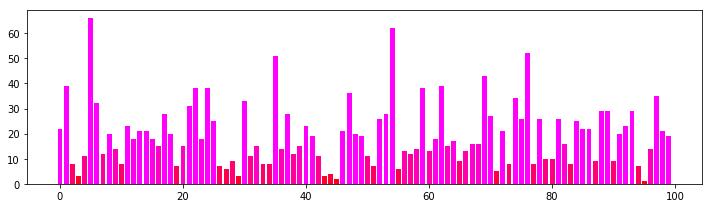

In [13]:
# Plot classes
points_per_class = []
for group in range(n_clusters):
    points_per_class.append(
        len(np.where(sequence_classes == group)[0]))

mean = np.mean(points_per_class)
maxv = np.max(points_per_class)

print('mean = {}, min = {}, max = {}'.format(mean,
                                             np.min(points_per_class),
                                             maxv))

strong_classes = len(np.where(points_per_class > mean)[0])
weak_classes = len(np.where(points_per_class < mean)[0])

print('classes > mean = {0}, classes < mean = {1}, ratio = {2:.2}'.format(
    strong_classes,
    weak_classes,
    strong_classes / weak_classes))

colors = [(1, 0, min(p / mean, 1)) for p in points_per_class]

plt.figure(figsize=(10, 3))
plt.bar(np.arange(n_clusters), points_per_class, color=colors)
plt.tight_layout()

In [14]:
kernel_size = 25

# Calculate average volume
rms_data = [x['rms'] for x in data]
rms_data = rms_data / np.max(rms_data)
kernel = np.array(np.full((kernel_size,), 1)) / kernel_size
rms_avg_data = np.convolve(rms_data, kernel, 'same')
rms_avg_data = rms_avg_data / np.max(rms_avg_data)

In [15]:
# Add class and volume to our data
for i, item in enumerate(data):
    data[i]['rms'] = rms_data[i]
    data[i]['rms_avg'] = rms_avg_data[i]
    data[i]['class'] = sequence_classes[i]

In [16]:
data[0]

{'class': 70,
 'end': 37376,
 'id': 1,
 'mfcc': array([-6.01940499,  1.12641121,  0.81314289,  0.48867106,  0.20179094,
        -0.05236269, -0.19857005, -0.15920535, -0.00941406,  0.0916797 ,
         0.10110667,  0.09724898,  0.10992962,  0.13211529,  0.12673261,
         0.1175437 ,  0.11783364,  0.12365821,  0.12545414,  0.12675445,
         0.13561786,  0.14579517,  0.14428469,  0.13303655,  0.12612152,
         0.12774141,  0.1129042 ,  0.1122247 ,  0.12453858,  0.13293939,
         0.13842577,  0.14552372,  0.14983992,  0.1447601 ,  0.13490311,
         0.13071894,  0.13300398,  0.13414949,  0.13235496]),
 'rms': 0.30328837,
 'rms_avg': 0.3269728273986363,
 'start': 30208}

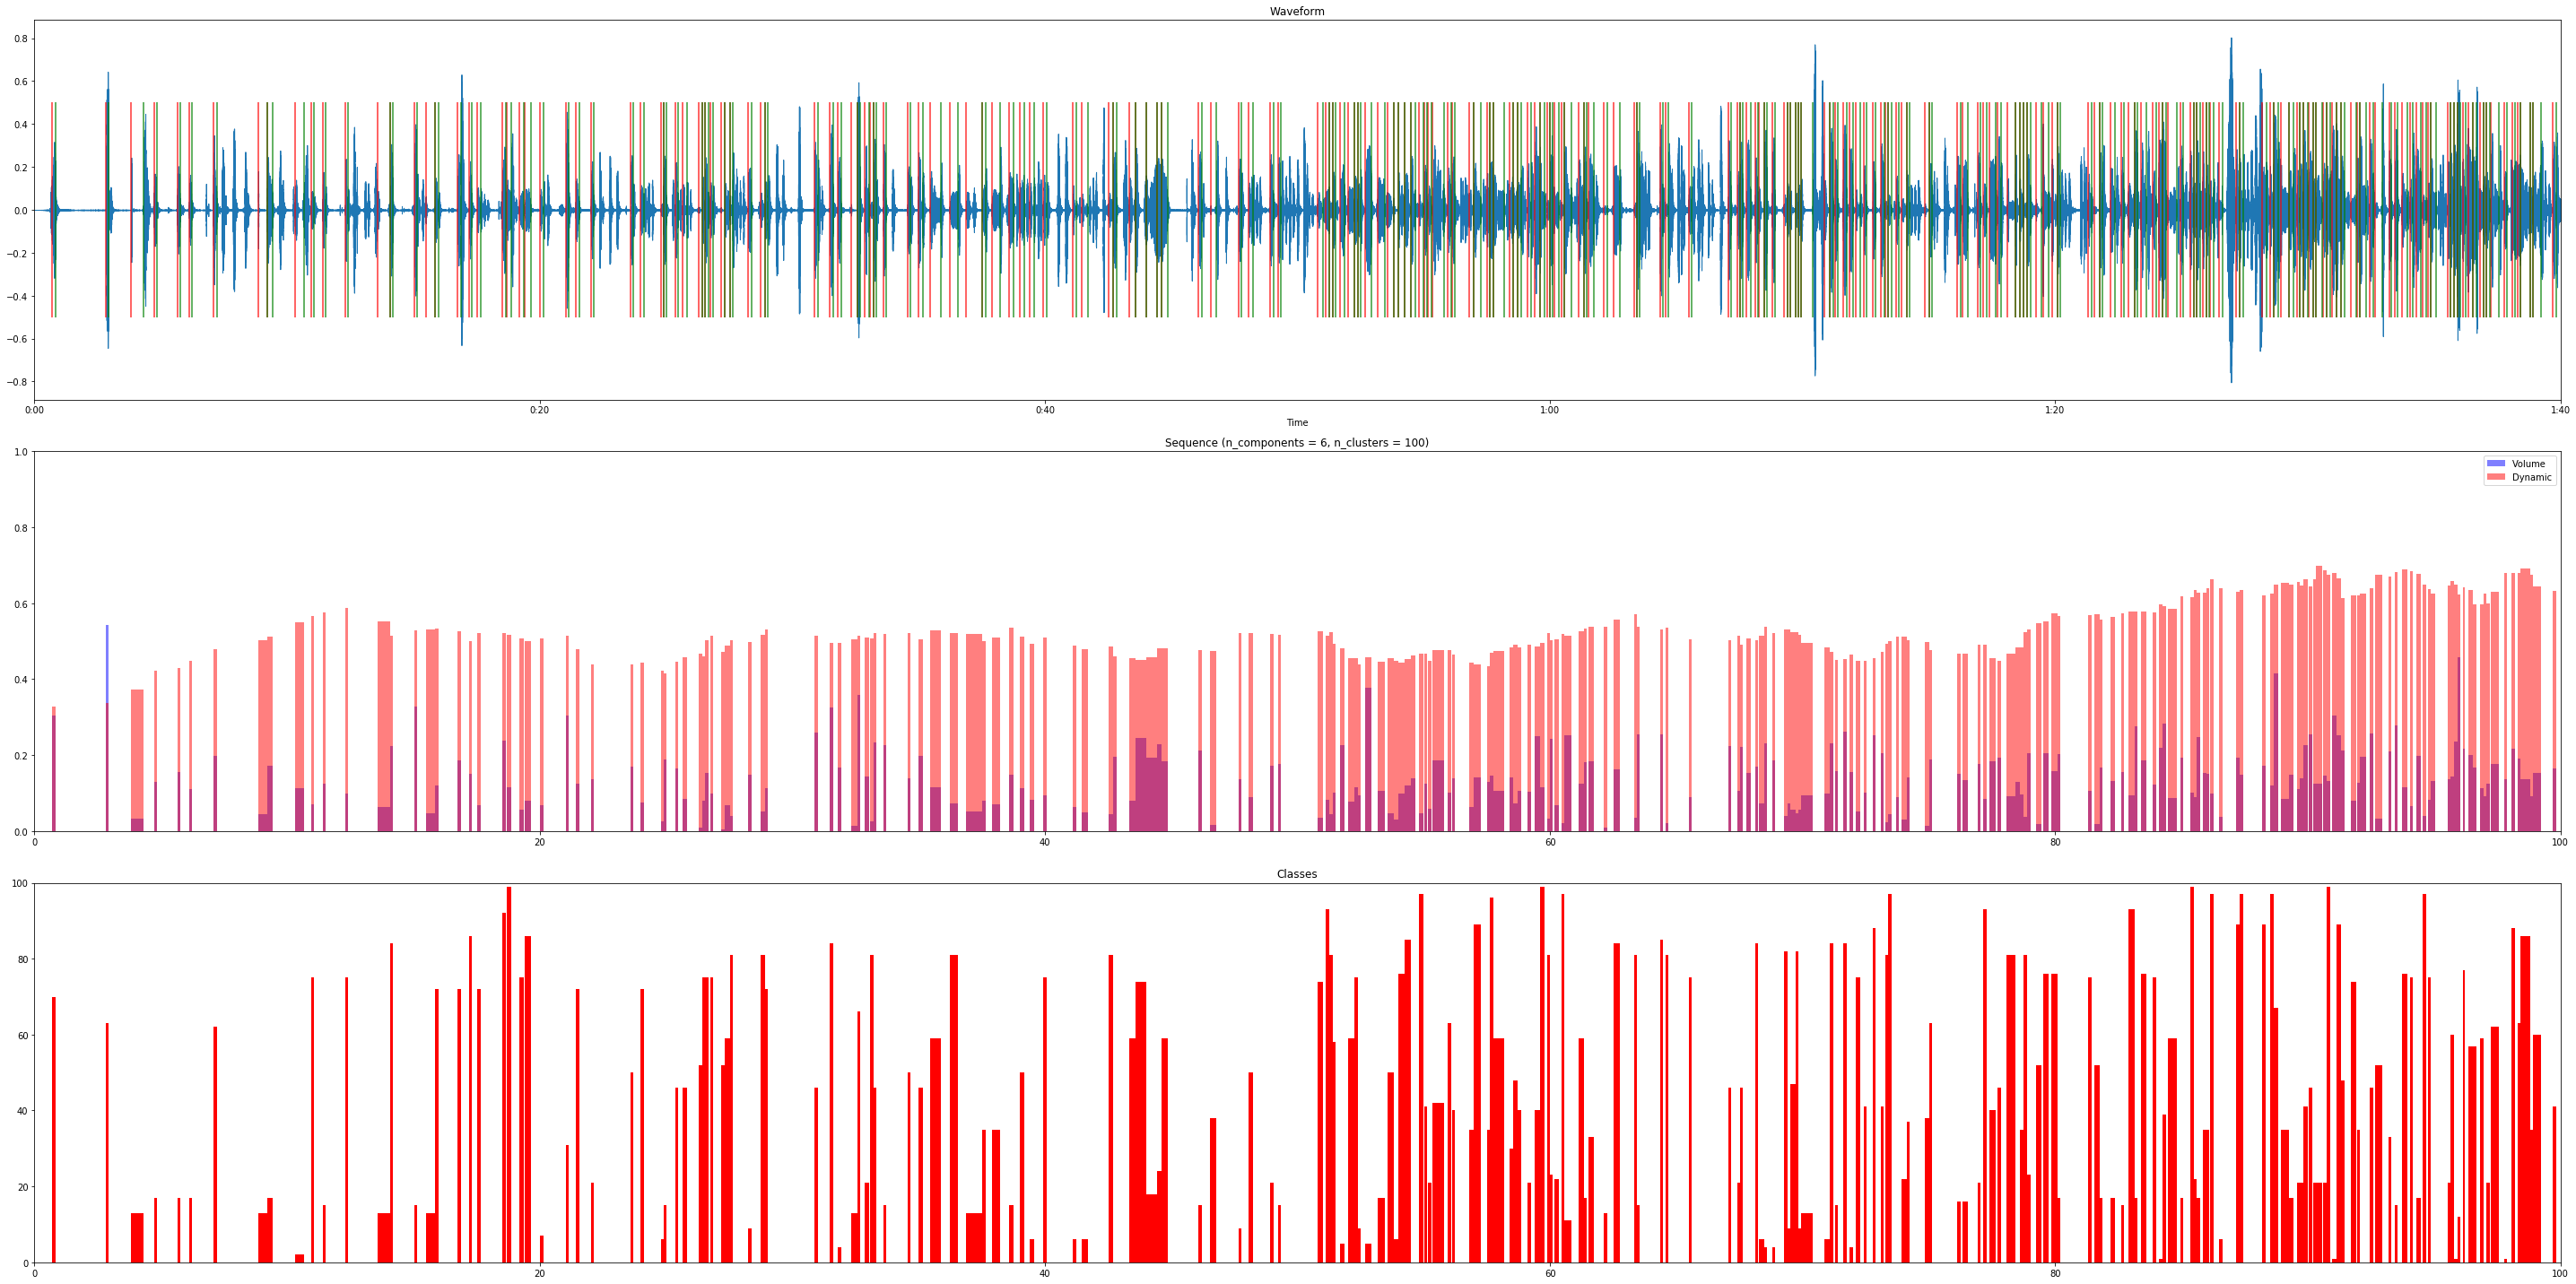

In [17]:
data_slice = 100
figsize = (40, 20)

# Convert start and end frames
c_starts = np.array([x['start'] for x in data]) / sr
c_ends = np.array([x['end'] for x in data]) / sr
c_width = c_ends - c_starts

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Start plot
fig = plt.figure(figsize=figsize)

# 1. Audio waveform
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Load full audio file
y, _ = librosa.load(file, sr=sr)

# Plot waveform
plt.subplot(3, 1, 1, title="Waveform")
librosa.display.waveplot(y[:data_slice*sr], sr=sr)

# Plot onsets
plt.vlines(c_starts, -0.5, 0.5,
           color='r',
           alpha=0.8)

plt.vlines(c_ends, -0.5, 0.5,
           color='g',
           alpha=0.8)

# 2. Plot sequence
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Plot sequence
plt.subplot(3, 1, 2, title="Sequence (n_components = {}, n_clusters = {})".format(
    n_components, n_clusters))

plt.axis([0, data_slice, 0, 1])

plt.bar(c_starts, [x['rms'] for x in data], width=c_width, align='edge', color='blue', alpha=0.5, label='Volume')
plt.bar(c_starts, [x['rms_avg'] for x in data], width=c_width, align='edge', color='red', alpha=0.5, label='Dynamic')

plt.legend(frameon=True)

# 3. Class
# ~~~~~~~~~~~~~~~~~~~~~~~~~

plt.subplot(3, 1, 3, title="Classes")

plt.axis([0, data_slice, 0, n_clusters])

plt.bar(c_starts, [x['class'] for x in data], width=c_width, align='edge', color='red', label='Class')

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot
plt.tight_layout()

In [11]:
fig.savefig('../plot-{}-{}.png'.format(n_clusters, n_components),
            bbox_inches='tight')